In [142]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
from matplotlib.animation import FuncAnimation, PillowWriter

from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D

# Random Field Generator

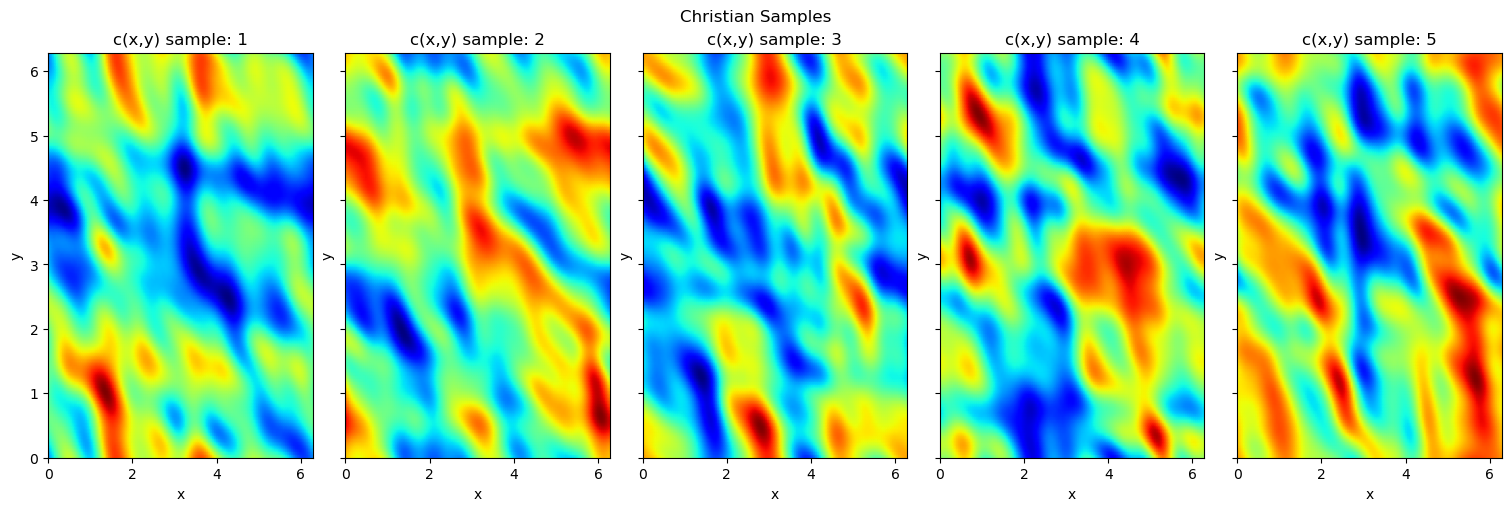

In [143]:
X = np.linspace(0, 1, 128)*2*np.pi  # Spatial grid in X direction
Y = np.linspace(0, 1, 128)*2*np.pi  # Spatial grid in Y direction
X, Y = np.meshgrid(X, Y)  # Create meshgrid for X, Y
n_samples = 5  # Number of samples you want to generate
seed = 108  # Base seed for reproducibility
N_KL = 100

rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,n_samples))

# Generate n samples of omega0
omega0_ = omega0_samples(X, Y, theta, d = 5,tau=7)

_, axs = plt.subplots(1,n_samples,figsize = (15,5), layout='constrained', sharey=True)
plt.suptitle("Christian Samples")
for i in range(n_samples):
    c = omega0_[:,:,i]

    axs[i].pcolormesh(X, Y, c, shading="gouraud", cmap = "jet")
    axs[i].set_xlabel("x"), axs[i].set_ylabel("y"), axs[i].set_title(f"c(x,y) sample: {i+1}")


# FEM Approach

In [ ]:
def forcing_function(x):
    return 0.1 * (np.sin(2 * np.pi * (x[0] + x[1])) + np.cos(2 * np.pi * (x[0] + x[1])))

fem_solver = VorticitySolver(nx=32, ny=32, N_KL=100, dt=0.01, T=10.0, nu=1e-4, force_func=None, d= 5, tau =10,seed = 108)

fem_solver.run()

Text(0, 0.5, 'y')

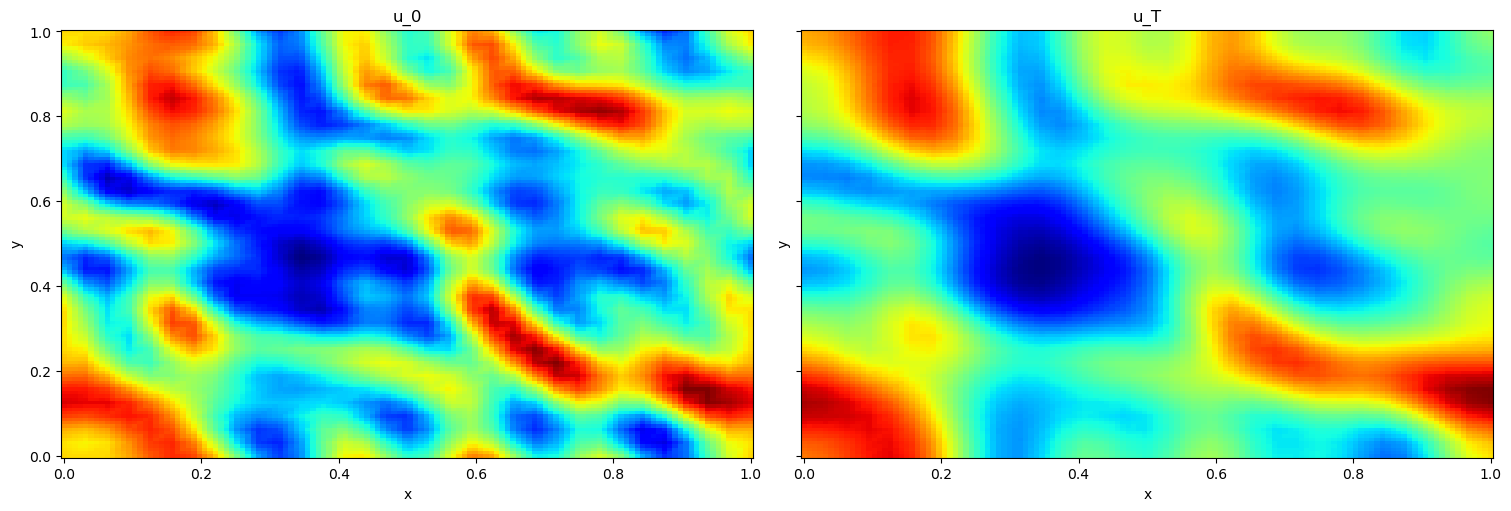

In [22]:
N = 128
xgrid = np.linspace(0,1,N)
X, Y = np.meshgrid(xgrid, xgrid)

points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

u_0,u_values =  fem_solver.evaluate_at_points(points)

fig, axs = plt.subplots(1,2,figsize = (15,5), layout='constrained', sharey=True)

z_0 = griddata((X.reshape(-1), Y.reshape(-1)), u_0.flatten(),
                   (X, Y), method='cubic')


z_pred = griddata((X.reshape(-1), Y.reshape(-1)), u_values.flatten(),
                   (X, Y), method='cubic')

# Plot the first subplot (Solution Visualization for u_0)
cp0 = axs[0].pcolormesh(X, Y, z_0, cmap='jet')
axs[0].set_title("u_0")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[1].pcolormesh(X, Y, z_pred, cmap='jet')
axs[1].set_title("u_T")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Pseudo Spectral Method

In [150]:
def force_function(X, Y):
    return 0.001 * (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=128, L=1, T=2.0, nu=1e-2, dt=5e-4,num_sol=100, method='CN',force = force_function)

results1 = solver.run_simulation( np.array(omega0_[:,:,0]))
results2 = solver.run_simulation( np.array(omega0_[:,:,1]))

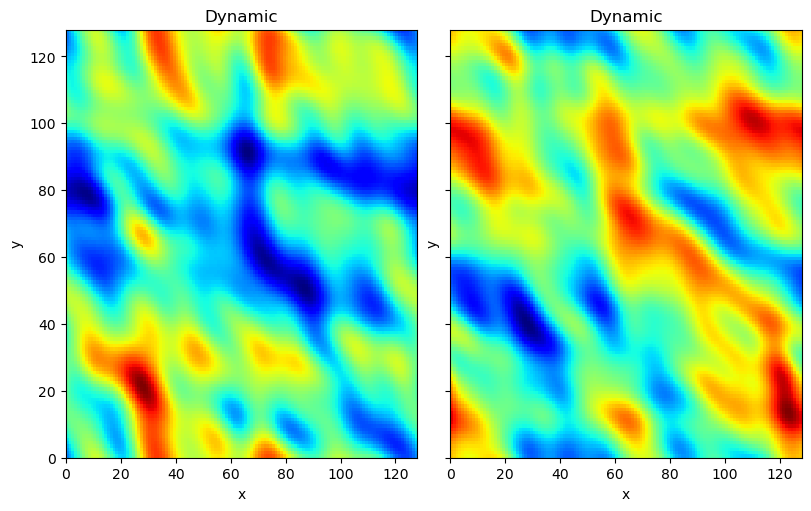

In [153]:
fig, axs = plt.subplots(1,2,figsize = (8,5), layout='constrained', sharey=True)

def animate(i):
    w0 = results1[i]
    w02 = results2[i]

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0].pcolormesh(w0, cmap='jet')
    #fig.colorbar(im1)
    axs[0].set_title(r"Dynamic")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    # Plot the first subplot (Solution Visualization for u_0)
    im2 = axs[1].pcolormesh(w02, cmap='jet')
    #fig.colorbar(im1)
    axs[1].set_title(r"Dynamic")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")
    return im1, im2

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
ani.save("./results/NVs_psm.gif", dpi=200, writer=PillowWriter(fps=50))

In [68]:
data = jnp.load("./data//ns_tori.npy", allow_pickle=True).item()
w_ref = data["w"]

solver = VorticitySolver2D(N=128, L=1, T=10.0, nu=1e-2, dt=5e-4,num_sol=200, method='CN')

results = solver.run_simulation( np.array(w_ref[0,:,:]))

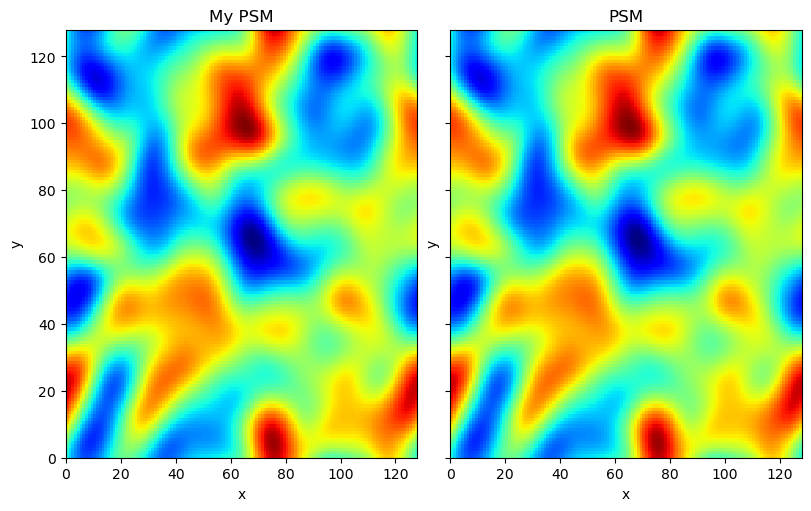

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (8,5), layout='constrained', sharey=True)

def animate(i):
    w0 = results[i]

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0].pcolormesh(w0, cmap='jet')
    #fig.colorbar(im1)
    axs[0].set_title(r"My PSM")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    im2 = axs[1].pcolormesh(w_ref[i,:,:], cmap='jet')
    #fig.colorbar(im1)
    axs[1].set_title(r"PSM")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")

    return im1,im2

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=200)    
ani.save("./results/NVs_comparison.gif", dpi=200, writer=PillowWriter(fps=50))

## PSM with Force

In [8]:
def force_function(X, Y):
    return 0.1 * (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=128, L=1, T=10.0, nu=1e-2, dt=5e-4,num_sol=50, method='CN', force=force_function)

results = solver.run_simulation( np.array(w_ref[0,:,:]))

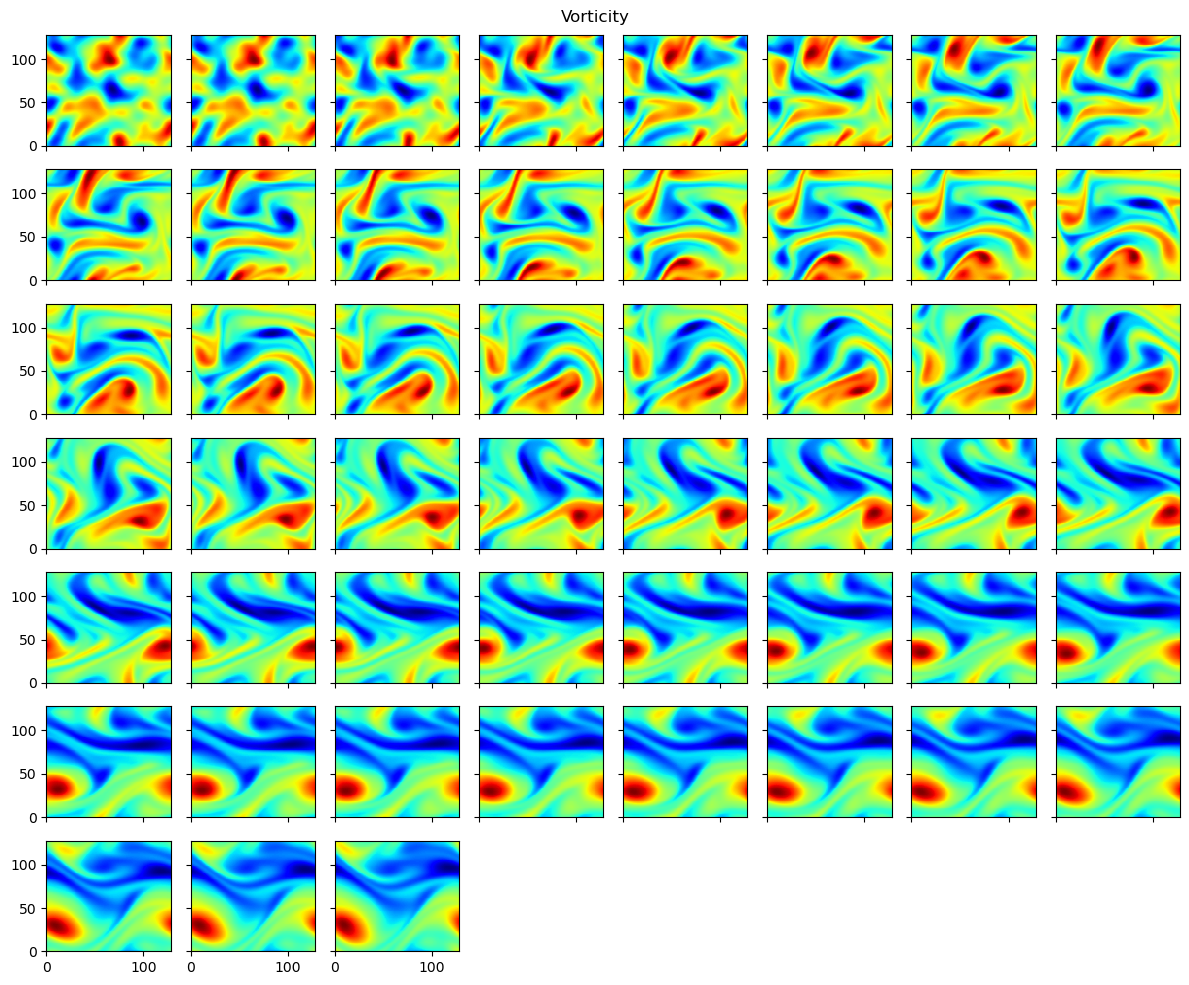

In [9]:
num_plots = len(results)
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

# Create a figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 10),sharex = True, sharey = True)
fig.suptitle("Vorticity")

# Flatten axes array for easy iteration if there's more than 1 row
axs = axs.flatten() if num_plots > 1 else [axs]

# Loop through each vorticity field in w_list and plot it
for i,j in enumerate(range(0,num_plots)):
    im = axs[i].pcolormesh(results[j], cmap="jet")
    #axs[i].set_title(f"Step {i*100}")
    #fig.colorbar(im, ax=axs[i])

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

# Convergence

In [29]:
seed = 108
N = 128
N_KL = 50
T = 1
dt = 5e-4
nu = 1e-2

xgrid = np.linspace(0,1,N)
X, Y = np.meshgrid(xgrid, xgrid)

#FEM
def force_function_FEM(x):
    return 0.1 * (np.sin(2 * np.pi * (x[0] + x[1])) + np.cos(2 * np.pi * (x[0] + x[1])))

fem_solver = VorticitySolver(nx=32, ny=32, N_KL=N_KL, dt=dt,T=T,nu=nu,force_func=force_function_FEM, d= 5, tau =10,seed = 108)

fem_solver.run()

points = np.column_stack((X.ravel(), Y.ravel(), np.zeros_like(X.ravel())))  # shape (N, 3)

u_0,u_final = fem_solver.evaluate_at_points(points)

z_0 = griddata((X.reshape(-1), Y.reshape(-1)), u_0.flatten(),(X, Y), method='cubic')

z_final = griddata((X.reshape(-1), Y.reshape(-1)), u_final.flatten(),(X, Y), method='cubic')

In [63]:
# PSM
xgrid = np.linspace(0,2*np.pi,N)
X, Y = np.meshgrid(xgrid, xgrid)
rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,1))

def force_function(X, Y):
    return 0.1 * (np.sin(X + Y) + np.cos(X + Y))

w0 = omega0_samples(X, Y, theta, d = 5,tau=10)

solver = VorticitySolver2D(N=128, L=1, T=T, nu=nu, dt=dt,num_sol=50, method='CN', force=force_function)

results = solver.run_simulation( np.array(w0[:,:,0]))

Text(0.5, 0, 'x')

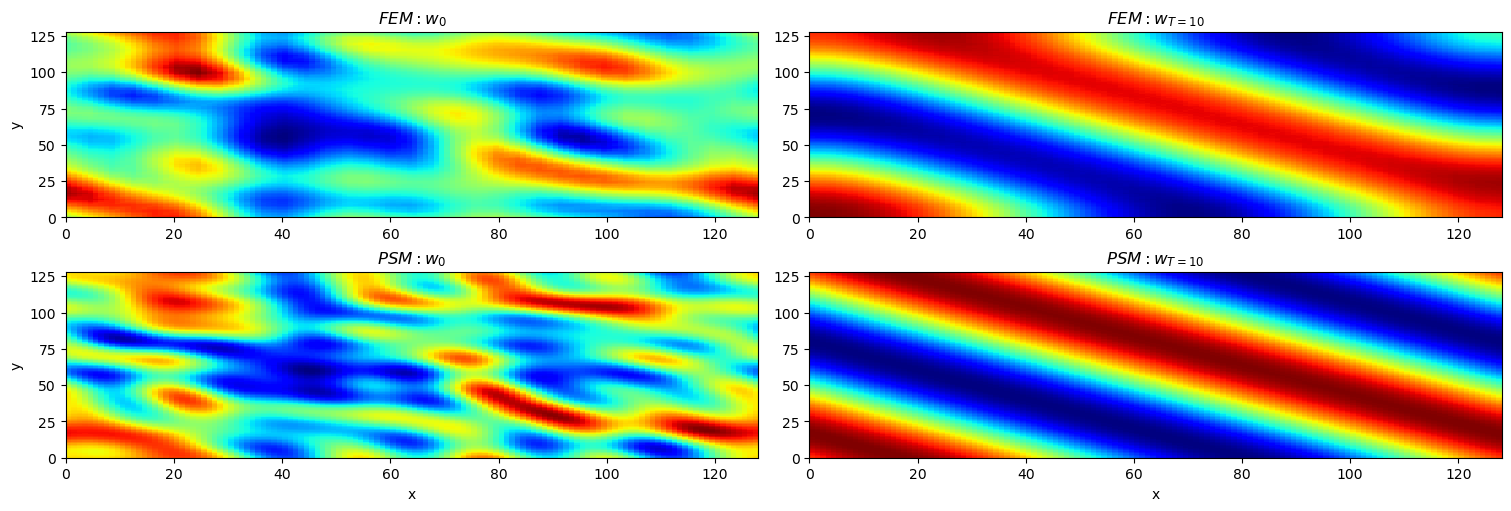

In [33]:
fig, axs = plt.subplots(2,2,figsize = (15,5), layout='constrained')

# Plot the first subplot (Solution Visualization for u_0)
cp0 = axs[0,0].pcolormesh(z_0, cmap='jet')
axs[0,0].set_title(r"$FEM: w_{0}$")
axs[0,0].set_ylabel("y")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[0,1].pcolormesh(z_final, cmap='jet')
axs[0,1].set_title(r"$FEM: w_{T=10}$")

cp0 = axs[1,0].pcolormesh(results[0], cmap='jet')
axs[1,0].set_title(r"$PSM: w_{0}$")
axs[1,0].set_ylabel("y")
axs[1,0].set_xlabel("x")

# Plot the second subplot (Solution Visualization for u_values)
cp1 = axs[1,1].pcolormesh(results[-1], cmap='jet')
axs[1,1].set_title(r"$PSM: w_{T=10}$")
axs[1,1].set_xlabel("x")

In [ ]:

# Function to interpolate a solution to a new grid
def interpolate_to_grid(solution, old_x, old_y, new_x, new_y):
    interpolator = interp2d(old_x, old_y, solution, kind='cubic')  # Use cubic interpolation
    return interpolator(new_x, new_y)

# Run simulations for increasing spatial resolutions
N_values = [64, 128, 256, 512,1024]
nu = 1e-2
solutions = {"NoF":[],"F":[]}
for N in N_values:

    old_x = np.linspace(0, 2 * np.pi, 128, endpoint=False)
    old_y = np.linspace(0, 2 * np.pi, 128, endpoint=False) 
    new_x = np.linspace(0, 2 * np.pi, N, endpoint=False) 
    new_y = np.linspace(0, 2 * np.pi, N, endpoint=False) 
    
    interpolated_solution = interpolate_to_grid(np.array(w_ref[0,:,:]), old_x, old_y, new_x, new_y)

    X, Y = np.meshgrid(np.linspace(0,2 * np.pi,N), np.linspace(0,2 * np.pi,N))
    w0 = omega0_samples(X, Y, theta, d = 5,tau=10)
    solver_force = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=5e-4,num_sol=5, method='CN', force=force_function)
    results_force = solver_force.run_simulation( interpolated_solution)
    solutions["F"].append(results_force[-1])

    solver = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=5e-4,num_sol=5, method='CN')
    results = solver.run_simulation( interpolated_solution)
    solutions["NoF"].append(results[-1])

In [39]:
# Initialize error dict
errors = {"NoF":[],"F":[]}

# Loop to compare successive resolutions
for i in range(1, len(N_values)):
        # Define the grids for the current and previous resolutions
    N_old = N_values[i-1]
    N_new = N_values[-1]
    
    old_x = np.linspace(0, 2 * np.pi, N_old, endpoint=False)
    old_y = np.linspace(0, 2 * np.pi, N_old, endpoint=False) 
    new_x = np.linspace(0, 2 * np.pi, N_new, endpoint=False) 
    new_y = np.linspace(0, 2 * np.pi, N_new, endpoint=False) 

    for typ in errors.keys():
        # Interpolate the lower-resolution solution to the higher-resolution grid
        interpolated_solution = interpolate_to_grid(solutions[typ][i-1], old_x, old_y, new_x, new_y)

        # Compute relative error norm
        error = np.linalg.norm(solutions[typ][-1] - interpolated_solution) / np.linalg.norm(solutions[typ][i])
        errors[typ].append(error)

In [ ]:
# Run simulations for decreasing time steps
N = 128
dt_values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
X, Y = np.meshgrid(np.linspace(0,2 * np.pi,N), np.linspace(0,2 * np.pi,N))
w0 = omega0_samples(X, Y, theta, d = 5,tau=10)

solutions_dt = {"NoF":[],"F":[]}
for dt in dt_values:
    solver_force = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=dt,num_sol=5, method='CN', force=force_function)
    results_force = solver_force.run_simulation( np.array(w_ref[0,:,:]))
    solutions_dt["F"].append(results_force[-1])

    solver = VorticitySolver2D(N=N, L=1, T=5, nu=nu, dt=dt,num_sol=50, method='CN')
    results = solver.run_simulation( np.array(w_ref[0,:,:]))
    solutions_dt["NoF"].append(results[-1])

In [53]:
# Compute errors between successive time steps
errors_dt = {"NoF":[],"F":[]}

for i in range(1, len(dt_values)):
    for typ in errors_dt.keys():
        error_dt = np.linalg.norm(solutions_dt[typ][i] - solutions_dt[typ][i-1]) / np.linalg.norm(solutions_dt[typ][i])
        errors_dt[typ].append(error_dt)

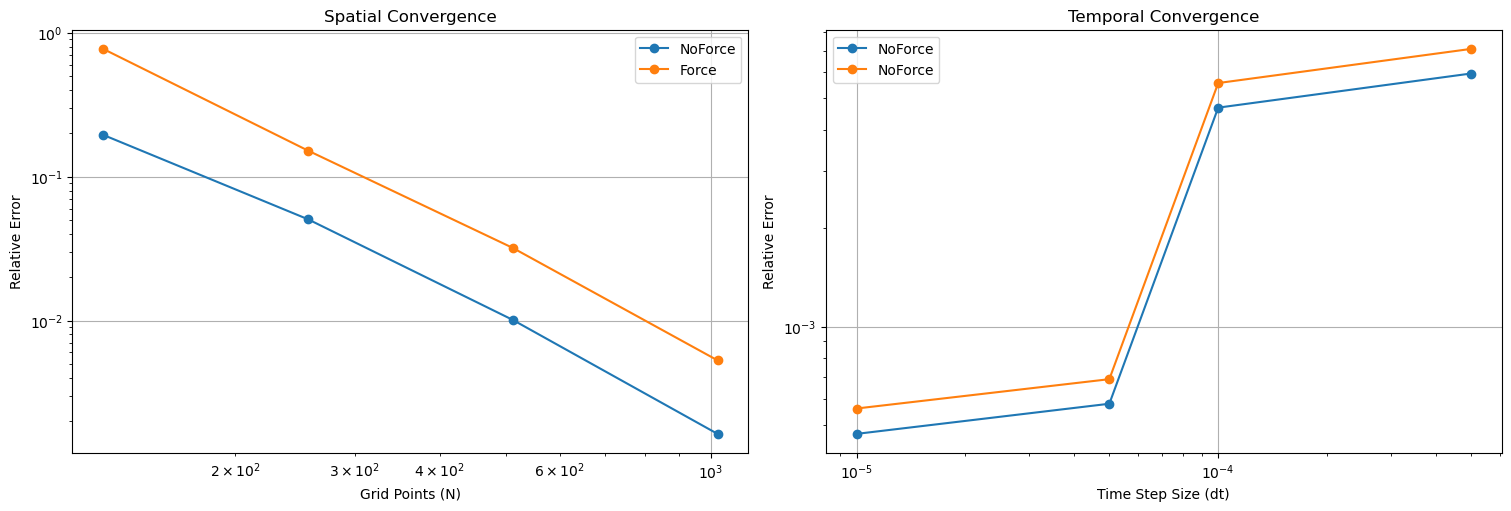

In [55]:
fig, axs = plt.subplots(1,2,figsize = (15,5), layout='constrained')

# Plot the first subplot (Solution Visualization for u_0)
axs[0].loglog(N_values[1:], errors["NoF"], '-o', label="NoForce")
axs[0].loglog(N_values[1:], errors["F"], '-o', label="Force")
axs[0].set_title(r"Spatial Convergence")
axs[0].set_xlabel("Grid Points (N)")
axs[0].set_ylabel("Relative Error")
axs[0].legend()
axs[0].grid()

axs[1].loglog(dt_values[1:], errors_dt["NoF"], '-o', label="NoForce")
axs[1].loglog(dt_values[1:], errors_dt["F"], '-o', label="NoForce")
axs[1].set_title(r"Temporal Convergence")
axs[1].set_xlabel("Time Step Size (dt)")
axs[1].set_ylabel("Relative Error")
axs[1].legend()
axs[1].grid()

# PINN

In [1]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import torch
import numpy as np
from ml_collections import ConfigDict
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from nv_files.data_generator import solve_poisson_fft,compute_velocity,UniformSampler
from nv_files.NavierStokes import NavierStokes
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
MDNN_model = torch.load(f"./models/MDNN_rnd.pth")
MDNN_model.eval()

mdnn_model = torch.load(f"./models/MDNN_epoch13000.pth")
mdnn_model.eval()

NavierStokes(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=256, out_features=256, bias=True)
    (v_layer): Linear(in_features=256, out_features=256, bias=True)
    (hidden_layers): ModuleList(
      (0-3): 4 x Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

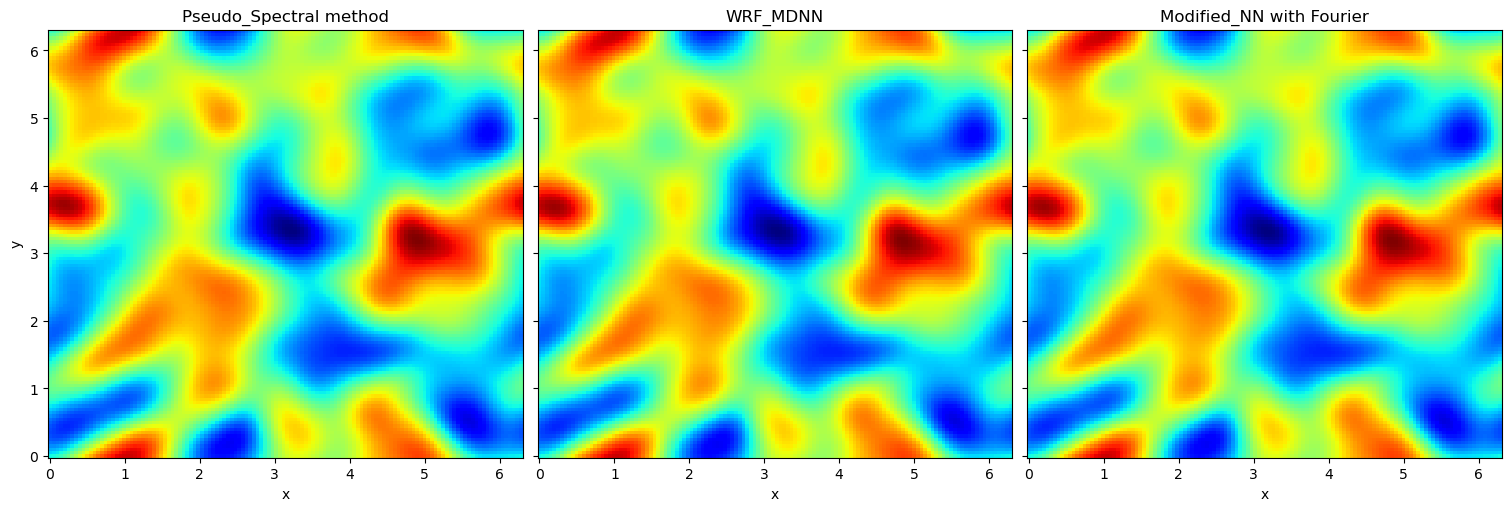

In [9]:

N = 128
seed = 108
N_KL = 50
xgrid = np.linspace(0,2*np.pi,N)
X, Y = np.meshgrid(xgrid, xgrid)
rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,1))

import jax.numpy as jnp

data = jnp.load("./data/ns_tori.npy", allow_pickle=True).item()
w_ref = data["w"]

#w0 = omega0_samples_torch(X, Y, theta, d = 5,tau=10)

solver = VorticitySolver2D(N=128, L=1, T=3, nu=1e-2, dt=5e-4,num_sol=200, method='CN', force=None)

w_list = solver.run_simulation( np.array(w_ref[0,:,:]))
time_array = np.linspace(5e-4, 3, int(1/ 5e-4))
points = np.linspace(0, len(time_array) - 1, 200, dtype=int)


time_steps = [0] + list(time_array[points])

batch_size_initial = 128

X = torch.linspace(0, 1, batch_size_initial)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, batch_size_initial)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

fig, axs = plt.subplots(1,3,figsize = (15,5), layout='constrained', sharey=True)

def animate(i):

    axs[0].clear()
    axs[1].clear()
    axs[2].clear()

    delta_t = time_steps[i]
    w0 = w_list[i]

    data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),delta_t*torch.ones_like(X.reshape(-1,1)))).float()

    wrf_pred = MDNN_model.w_net(data_test).detach().numpy()
    mdnn_pred = mdnn_model.w_net(data_test).detach().numpy()

    w_pred_mdnn = griddata((X.reshape(-1), Y.reshape(-1)), mdnn_pred.flatten(), (X, Y), method='cubic')
    w_pred_wrfdnn = griddata((X.reshape(-1), Y.reshape(-1)), wrf_pred.flatten(),(X, Y), method='cubic')

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0].pcolormesh(X, Y, w0, cmap='jet')
    #fig.colorbar(im1)
    axs[0].set_title("Pseudo_Spectral method")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    im2 = axs[1].pcolormesh(X, Y, w_pred_wrfdnn, cmap='jet')
    #fig.colorbar(im2)
    axs[1].set_title("WRF_MDNN")
    axs[1].set_xlabel("x")

    im3 = axs[2].pcolormesh(X, Y, w_pred_mdnn, cmap='jet')
    #fig.colorbar(im3)
    axs[2].set_title("Modified_NN with Fourier")
    axs[2].set_xlabel("x")

    return im1, im2, im3

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
ani.save("./results/NV_NNs.gif", dpi=300, writer=PillowWriter(fps=25))

In [9]:
def get_deepgalerkin_config():
    config = ConfigDict()

    # Training settings
    config.seed = 108

    config.chunks = 16
    config.points_per_chunk = 180 

    # For deep Galerkin
    config.dim_initial_condition = 128
    config.NKL =  50
    config.samples_size_initial = 15
    
    return config

In [10]:
from nv_files.train_nvs import initial_conditions_samples

config = get_deepgalerkin_config()

initial_points,w0,u0,v0,theta = initial_conditions_samples(config)

WRF_MDNN_dg = torch.load(f"./models/MDNN_dg_epoch500.pth")
WRF_MDNN_dg.eval()

NavierStokes(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=356, out_features=356, bias=True)
    (v_layer): Linear(in_features=356, out_features=356, bias=True)
    (hidden_layers): ModuleList(
      (0-3): 4 x Linear(in_features=356, out_features=356, bias=True)
    )
    (output_layer): Linear(in_features=356, out_features=2, bias=True)
  )
)

In [7]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

solver = VorticitySolver2D(N=128, L=1, T=2, nu=1e-2, dt=5e-4,num_sol=200, method='CN', force=None)

w_ref1 = griddata((X.reshape(-1), Y.reshape(-1)), w0[:,0].flatten(),(X, Y), method='cubic')
w_ref2 = griddata((X.reshape(-1), Y.reshape(-1)), w0[:,2].flatten(),(X, Y), method='cubic')


w_list1 = solver.run_simulation( np.array(w_ref1))
w_list2 = solver.run_simulation( np.array(w_ref2))

def parameters_data(theta, data):
    # Repeat the flattened `theta` for the number of rows in `data`
    theta_ = theta.view(-1).repeat(data.size(0), 1)  # Flatten and repeat

    # Concatenate `data` and `theta_` along the last dimension
    return torch.cat((data, theta_), dim=1)

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /croot/pytorch-select_1725478810240/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


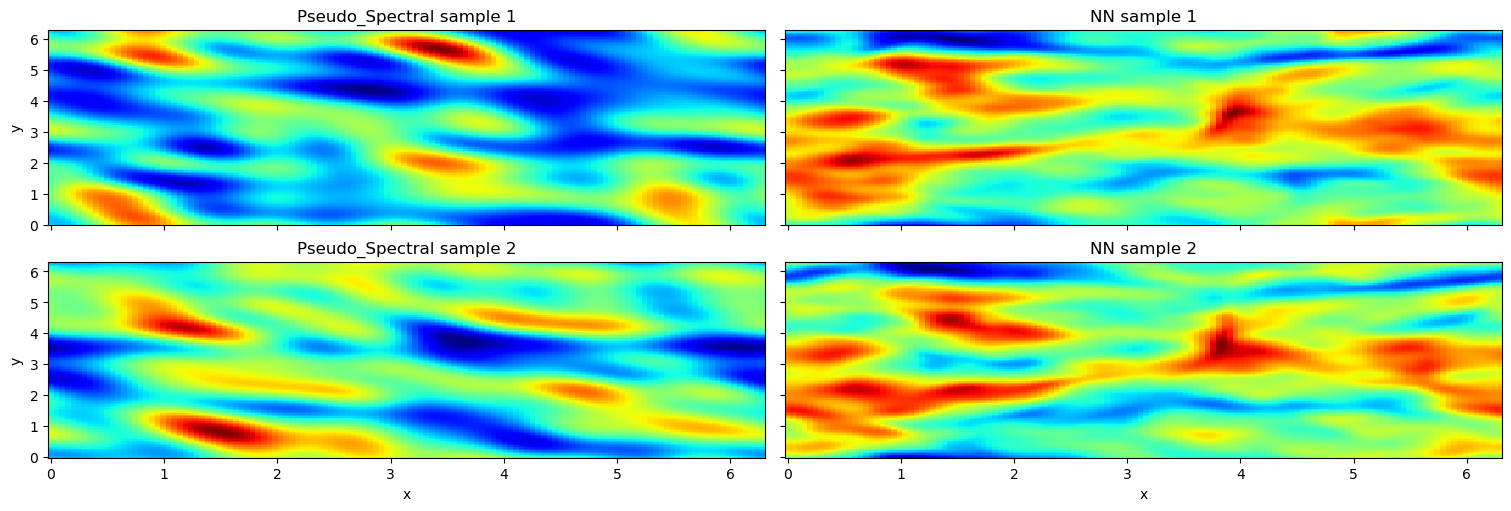

In [7]:
time_array = np.linspace(5e-4, 2, int(1/ 5e-4))
points = np.linspace(0, len(time_array) - 1, 200, dtype=int)

time_steps = [0] + list(time_array[points])


fig, axs = plt.subplots(2,2,figsize = (15,5), layout='constrained', sharey=True, sharex=True)

def animate(i):

    axs[0,0].clear()
    axs[1,0].clear()
    axs[0,1].clear()
    axs[1,1].clear()

    delta_t = time_steps[i]
    w01 = w_list1[i]
    w02 = w_list2[i]

    data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),delta_t*torch.ones_like(X.reshape(-1,1)))).float()

    dataset1 = parameters_data(theta[:,:,0], data_test)
    dataset2 = parameters_data(theta[:,:,1], data_test)

    nn_pred1 = WRF_MDNN_dg.w_net(dataset1).detach().numpy()
    nn_pred2 = WRF_MDNN_dg.w_net(dataset2).detach().numpy()

    pred1 = griddata((X.reshape(-1), Y.reshape(-1)), nn_pred1.flatten(),(X, Y), method='cubic')
    pred2 = griddata((X.reshape(-1), Y.reshape(-1)), nn_pred2.flatten(),(X, Y), method='cubic')

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0,0].pcolormesh(X, Y, w01, cmap='jet')
    axs[0,0].set_title("Pseudo_Spectral sample 1")
    axs[0,0].set_ylabel("y")

    im2 = axs[1,0].pcolormesh(X, Y, w02, cmap='jet')
    axs[1,0].set_title("Pseudo_Spectral sample 2")
    axs[1,0].set_xlabel("x")
    axs[1,0].set_ylabel("y")

    im3 = axs[0,1].pcolormesh(X, Y, pred1, cmap='jet')
    axs[0,1].set_title("NN sample 1")

    im4 = axs[1,1].pcolormesh(X, Y, pred2, cmap='jet')
    axs[1,1].set_title("NN sample 2")
    axs[1,1].set_xlabel("x")

    return im1,im2,im3,im4

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
ani.save("./results/NV_NN_dg.gif", dpi=300, writer=PillowWriter(fps=25))

In [ ]:
from data_generator import solve_poisson_fft,compute_velocity,UniformSampler
from Training import compute_loss

numpy_x = np.load("numpy_x.npy")
numpy_y = np.load("numpy_y.npy")
numpy_w = np.load("numpy_w.npy")

X, Y = torch.meshgrid(torch.tensor(numpy_x), torch.tensor(numpy_y),indexing="ij")
dx, dy = X[1, 0] - X[0, 0], Y[0, 1] - Y[0, 0]
w0 = torch.tensor(numpy_w).unsqueeze(-1)

psi = solve_poisson_fft(w0, dx, dy)
u0, v0 = compute_velocity(psi, dx, dy)

initial_points = torch.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), torch.zeros_like(X.reshape(-1, 1))])
initial_condition = torch.hstack([w0.reshape(-1, 1), u0.reshape(-1, 1), v0.reshape(-1, 1)])

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi]]).to(device)

fourier_emb = {"embed_scale" : 1, "embed_dim" :256, "input_dim":3}
period_emb_config = {"period": (1.0, 1.0), "axis": (0, 1)}
reparam = {"type":"weight_fact","mean":0.5,"stddev":0.1}
# Define model, optimizer, scheduler, etc.

loss_fn = torch.nn.MSELoss(reduction ='mean')

# Define model, optimizer, scheduler, etc.
wrf_MDNN_model = WRF_MDNN(num_layers=4, hidden_dim=256, out_dim=2, 
                 input_dim=3,
                 fourier_emb = fourier_emb,
                 reparam=reparam, period_emb=period_emb_config).to(device)

MDNN_model = MDNN(num_layers=4, hidden_dim=256, out_dim=2, 
                 input_dim=(3),fourier_emb = fourier_emb, period_emb = period_emb_config).to(device)

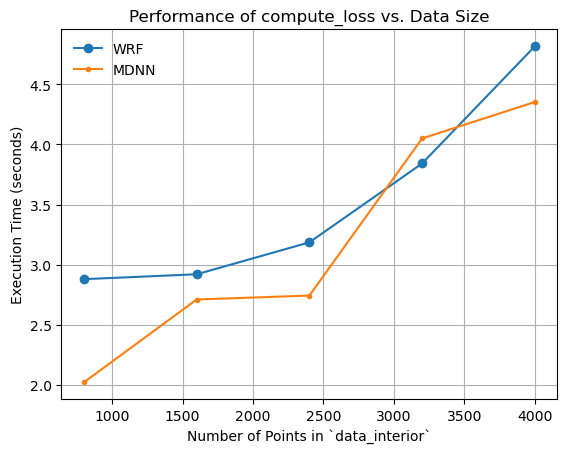

In [18]:
import time
import matplotlib.pyplot as plt

sizes = [16*i for i in range(50,300,50)]  # Varying number of points in `data_interior`
times = {"WRF":[],"MDNN":[]}
models = {"WRF":wrf_MDNN_model,"MDNN":MDNN_model}

for model in models.keys():
    for size in sizes:
        samples_interior = iter(UniformSampler(dom, size))
        timedomain = torch.linspace(0,1,size).reshape(-1, 1)
        batch = next(samples_interior)
        sorted_batch = torch.cat((batch, timedomain), dim=1).to(device)

        start_time = time.time()
        total_loss, _, _ = compute_loss(models[model], loss_fn, sorted_batch, initial_points, initial_condition, [1]*5)
        end_time = time.time()
        times[model].append(end_time - start_time)

# Plot Results
plt.plot(sizes, times["WRF"], marker='o',label = "WRF")
plt.plot(sizes, times["MDNN"], marker='.',label = "MDNN")

plt.xlabel('Number of Points in `data_interior`')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance of compute_loss vs. Data Size')
plt.legend(frameon = False)
plt.grid(True)
plt.show()

In [10]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import torch
import wandb
import numpy as np
from ml_collections import ConfigDict
from nv_files.train_nvs import train_pinn_nvs
from nv_files.data_generator import solve_poisson_fft,compute_velocity,UniformSampler

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [15]:
def get_deepgalerkin_config():
    config = ConfigDict()

    # Training settings
    config.seed = 108

    config.chunks = 16
    config.points_per_chunk = 100 

    # For deep Galerkin
    config.dim_initial_condition = 100
    config.NKL =  50
    config.samples_size_initial = 15
    
    return config

In [16]:
from nv_files.train_nvs import initial_conditions_samples

config = get_deepgalerkin_config()

WRF_MDNN_dg = torch.load(f"./models/MDNN_dg_epoch500.pth")
WRF_MDNN_dg.eval()

NavierStokes(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=356, out_features=356, bias=True)
    (v_layer): Linear(in_features=356, out_features=356, bias=True)
    (hidden_layers): ModuleList(
      (0-3): 4 x Linear(in_features=356, out_features=356, bias=True)
    )
    (output_layer): Linear(in_features=356, out_features=2, bias=True)
  )
)

In [17]:
# Domain and sampler setup
chunks = 16
points_per_chunk = 100 
time_domain =2

batch_size_interior = chunks*points_per_chunk

initial_points,w0,u0,v0,theta = initial_conditions_samples(config)

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi],[0,time_domain]]).to(device)

samples_interior = iter(UniformSampler(dom, batch_size_interior))

batch = next(samples_interior).to(device)

_, indices = batch[:, -1].sort()  # Sort based on the time column

sorted_batch = batch[indices]    # Rearrange rows based on sorted indices



In [18]:
def parameters_data(theta, data):
    # Repeat the flattened `theta` for the number of rows in `data`
    theta_ = theta.view(-1).repeat(data.size(0), 1)  # Flatten and repeat

    # Concatenate `data` and `theta_` along the last dimension
    return torch.cat((data, theta_), dim=1)

In [19]:
from nv_files.NavierStokes import NavierStokes

def get_deepgalerkin_config():
    config = ConfigDict()

    # Weights & Biases
    config.wandb = wandb = ConfigDict()
    wandb.project = "NVs-Training-dg"
    wandb.name = "MDNN"
    wandb.tag = None

    # General settings
    config.nn_model = "MDNN"  # Options: "NN", "WRF", "MDNN"
    config.lambdas = {"nvs":1, "cond":1, "u0":1, "v0":1, "w0":1}
    config.use_softadapt = False

    # Model-specific settings
    config.model = ConfigDict()
    config.model.input_dim = 3 + 100
    config.model.hidden_dim = 256
    config.model.num_layers = 4
    config.model.out_dim = 2
    config.model.activation = "tanh"

    # Weight-Random-Factorization
    #config.reparam = ConfigDict({"type":"weight_fact","mean":1.0,"stddev":0.1})

     # Periodic embeddings
    config.model.period_emb = ConfigDict({"period":(1.0, 1.0), "axis":(0, 1) })

    # Fourier embeddings
    config.model.fourier_emb = ConfigDict({"embed_scale":1,"embed_dim":256,"exclude_last_n":100})

    # Navier Stokes Config
    config.nu = 1e-2
    config.time_domain = 2

    # Training settings
    config.seed = 108
    config.learning_rate = 0.001
    config.decay_rate = 0.9
    config.alpha = 0.9  # For updating loss weights
    config.iterations = 10000
    config.start_scheduler = 0.1
    config.weights_update = 500
    config.scheduler_step = 2000

    config.chunks = 16
    config.points_per_chunk = 180 

    # For deep Galerkin
    config.dim_initial_condition = 128
    config.NKL =  50
    config.samples_size_initial = 15
    
    return config

config = get_deepgalerkin_config()
MDNN_dg = NavierStokes(config=config, device=device)

In [20]:
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torch.distributions.multivariate_normal import _precision_to_scale_tril

from Base.utilities import FeatureExtractor
from copy import deepcopy
from math import sqrt, pi
from  Base.utilities import get_decorated_methods

class dgala(torch.nn.Module):
    def __init__(self, dga, sigma_noise=1., prior_precision=1.,prior_mean=0.):
        super(dgala, self).__init__()

        self.dgala = deepcopy(dga)
        self.model = FeatureExtractor(deepcopy(dga.model), last_layer_name = "output_layer")
        self._device = next(dga.model.parameters()).device
        
        self.loss = 0
        self.temperature = 1
        self.H = None
        self.mean = None
        self.n_params = None

        self._prior_precision = torch.tensor([prior_precision], device=self._device)
        self._prior_mean = torch.tensor([prior_mean], device=self._device)
        self.sigma_noise = torch.tensor(sigma_noise,device=self._device).float()

        if hasattr(self.dgala, "chunks"):
            self.chunks = self.dgala.chunks
    
    @property
    def posterior_precision(self):
        """Diagonal posterior precision \\(p\\)."""
        return self._H_factor * self.H + torch.diag(self.prior_precision_diag)

    @property
    def posterior_covariance(self):
        """Diagonal posterior variance \\(p^{-1}\\).""" 
        post_scale = _precision_to_scale_tril(self.posterior_precision)
        return post_scale @ post_scale.T

    @property
    def _H_factor(self):
        sigma2 = self.sigma_noise.square()
        return 1 / sigma2 / self.temperature
    
    @property
    def prior_precision_diag(self):
        """Obtain the diagonal prior precision \\(p_0\\) constructed from either
        a scalar, layer-wise, or diagonal prior precision."""

        if len(self.prior_precision) == 1:  # scalar
            return self.prior_precision * torch.ones(self.n_params, device=self._device)

        elif len(self.prior_precision) == self.n_params:  # diagonal
            return self.prior_precision
        
    @property
    def scatter(self):
        """Computes the _scatter_, a term of the log marginal likelihood that
        corresponds to L-2 regularization:
        `scatter` = \\((\\theta_{MAP} - \\mu_0)^{T} P_0 (\\theta_{MAP} - \\mu_0) \\)."""

        delta = (self.mean - self.prior_mean)
        return (delta * self.prior_precision_diag) @ delta

    @property
    def log_det_prior_precision(self):
        """Compute log determinant of the prior precision
        \\(\\log \\det P_0\\)"""

        return self.prior_precision_diag.log().sum()

    @property
    def log_det_posterior_precision(self):
        """Compute log determinant of the posterior precision
        \\(\\log \\det P\\) which depends on the subclasses structure
        used for the Hessian approximation."""
        return self.posterior_precision.logdet()

    @property
    def log_det_ratio(self):
        """Compute the log determinant ratio, a part of the log marginal likelihood.
        \\[
            \\log \\frac{\\det P}{\\det P_0} = \\log \\det P - \\log \\det P_0
        \\]log"""
        return self.log_det_posterior_precision - self.log_det_prior_precision
    
    @property
    def log_likelihood(self):
        """Compute log likelihood on the training data after `.fit()` has been called.
        The log likelihood is computed on-demand based on the loss and, for example,
        the observation noise which makes it differentiable in the latter for
        iterative updates."""

        factor = - self._H_factor
        # loss used is just MSE, need to add normalizer for gaussian likelihood
        c = self.n_data  * torch.log(self.sigma_noise * sqrt(2 * pi))
        return factor * self.loss - c

    def fit(self,fit_data):
        """Fit the local Laplace approximation at the parameters of the model."""
        
        self.class_methods = get_decorated_methods(self.dgala, decorator = "use_laplace")

        assert set(self.class_methods) == set([element for sublist in fit_data["class_method"].values() for element in sublist])

        self.dgala.model.eval()
        params = parameters_to_vector(self.dgala.model.output_layer.parameters()).detach()
        self.n_params = len(params)
        self.prior_precision = self._prior_precision
        self.prior_mean = self._prior_mean
        self._init_H()

        self.mean = parameters_to_vector(self.dgala.model.output_layer.parameters()).detach()

        self.full_Hessian(fit_data)
        
    def _init_H(self):
        self.H = torch.zeros(self.n_params,self.n_params,device=self._device)

    def gradient_outograd(self, y, x):
        grad_p = torch.autograd.grad(outputs=y, 
                                 inputs=x, create_graph=True, allow_unused=True, materialize_grads=True)
        return [grp.detach() for grp in grad_p]
    

    def full_Hessian(self,fit_data, damping_factor=1e-5):
        #self.hessian_losses = dict()
        parameters_ = list(self.dgala.model.output_layer.parameters())
        damping = torch.eye(self.n_params,device=self._device)*damping_factor

        for key in fit_data["data_fit"].keys():
            for z,clm in enumerate(fit_data["class_method"][key]):

                self.dgala.model.zero_grad()
                fout = getattr(self.dgala, clm)(fit_data["data_fit"][key])

                if isinstance(fout, tuple):  # Check if fout is a tuple
                    for i in range(len(fout)):  # Iterate over fout if it's a tuple
                        indv_h = self.compute_hessian(fout[i],parameters_)
                        self. H += (indv_h + damping)*self.dgala.lambdas[fit_data["outputs"][key][i]]
                        #self.hessian_losses[fit_data["outputs"][key][i]]  =  indv_h             
                else:
                    indv_h = self.compute_hessian(fout[i],parameters_)
                    self. H += (indv_h + damping)*self.dgala.lambdas[fit_data["outputs"][key][i]]
                    #self.hessian_losses[fit_data["outputs"][key][z]]  = indv_h
                
    def compute_hessian (self,output,parameters_):
        hessian_loss = torch.zeros(self.n_params,self.n_params)

        for fo in output:
            grad_p = self.gradient_outograd(fo,parameters_)
            
            ndim = grad_p[0].shape[0]

            reshaping_grads = [g.reshape(ndim,-1) for g in grad_p]
            # Concatenate along the parameter axis
            jacobian_matrix = torch.cat(reshaping_grads, dim=1).flatten().unsqueeze(0) 

            hessian_loss +=  jacobian_matrix.T @ jacobian_matrix
        return hessian_loss
        

    def __call__(self, x):
        """Compute the posterior predictive on input data `X`."""
        f_mu, f_var = self._glm_predictive_distribution(x)
        return f_mu, f_var


    def _glm_predictive_distribution(self, X):
        Js, f_mu = self.last_layer_jacobians(X)
        f_var = self.functional_variance(Js)
        if f_mu.shape[-1] > 1:
            f_var = torch.diagonal(f_var, dim1 = 1, dim2 = 2)
        return f_mu.detach(), f_var.detach()

    def last_layer_jacobians(self, x):
        """
        Compute Jacobians \\(\\nabla_{\\theta_\\textrm{last}} f(x;\\theta_\\textrm{last})\\) 
        only at current last-layer parameter \\(\\theta_{\\textrm{last}}\\).
        """
        f, phi = self.model.forward_with_features(x)
        bsize = phi.shape[0]
        output_size = f.shape[-1]

        if self.model.last_layer.bias is not None:
            phi = torch.cat([phi, torch.ones(f.shape[0],1).to(self._device)], dim=1)
        # calculate Jacobians using the feature vector 'phi'
        identity = torch.eye(output_size, device=x.device).unsqueeze(0).tile(bsize, 1, 1)
        # Jacobians are batch x output x params
        Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
        # if self.model.last_layer.bias is not None:
        #     Js = torch.cat([Js, identity], dim=2)
        return Js, f.detach()
    

    def functional_variance(self, Js: torch.Tensor) -> torch.Tensor:
        return torch.einsum('ncp,pq,nkq->nck', Js, self.posterior_covariance, Js)
    
  
    def log_marginal_likelihood(self, prior_precision=None, sigma_noise=None):
        """Compute the Laplace approximation to the log marginal likelihood
        """
        # update prior precision (useful when iterating on marglik)
        if prior_precision is not None:
            self.prior_precision = prior_precision

        # update sigma_noise (useful when iterating on marglik)
        if sigma_noise is not None:
            self.sigma_noise = sigma_noise

        return self.log_likelihood - 0.5 * (self.log_det_ratio + self.scatter)
    
    def optimize_marginal_likelihood(self, error_tolerance=1e-3, max_iter=300, lr=1e-2):
        """Optimize the log prior and log sigma by maximizing the marginal likelihood."""

        log_prior_prec = self.prior_precision.log()
        log_prior_prec.requires_grad = True

        log_sigma_noise = self.sigma_noise.log()
        log_sigma_noise.requires_grad = True

        hyper_optimizer = torch.optim.Adam([log_prior_prec, log_sigma_noise], lr=lr)

        error,n_iter = float('inf'),0  # Initialize error

        while error > error_tolerance and n_iter < max_iter:
            prev_log_prior, prev_log_sigma = log_prior_prec.detach().clone(), log_sigma_noise.detach().clone()

            hyper_optimizer.zero_grad()

            # Calculate negative marginal likelihood
            neg_marglik = -self.log_marginal_likelihood(log_prior_prec.exp(), log_sigma_noise.exp())
            neg_marglik.backward(retain_graph=True)

            # Perform optimization step
            hyper_optimizer.step()

            # Calculate the error based on the change in hyperparameters
            error = 0.5 * (torch.abs(log_prior_prec - prev_log_prior) + torch.abs(log_sigma_noise - prev_log_sigma)).item()

            n_iter += 1

            # Optional: log progress for monitoring
            if n_iter % 100 == 0:
                print(f"Iteration {n_iter}, Error: {error:.5f}, neg_marglik: {neg_marglik.item():.5f}")

        self.prior_precision = log_prior_prec.detach().exp()
        self.log_sigma_noise = log_sigma_noise.detach().exp()

        if n_iter == max_iter:
            print(f"Maximum iterations ({max_iter})reached, sigma : {self.sigma_noise.item()}, prior: {self.prior_precision.item()}.")


In [21]:
sorted_batch = parameters_data(theta=theta[:,:,0], data=sorted_batch).to(device)

initial_points_ = parameters_data(theta=theta[:,:,0], data=initial_points).to(device)

data_trainig = {
                "data_fit": {"pde":sorted_batch, "initial_conditions":initial_points_}, 
                "class_method": {"pde": ["nv_pde"], "initial_conditions":["u", "v", "w_net"]},
                "outputs": {"pde": ["nvs", "cond"], "initial_conditions": ["u0", "v0", "w0"]}
                }

In [22]:
llp = dgala(WRF_MDNN_dg)

In [23]:
llp.fit(data_trainig)

In [25]:
llp(sorted_batch)

(tensor([[-2.5246e-03,  7.5443e-04],
         [-4.6433e-03,  8.4138e-04],
         [-3.3407e-03,  1.7902e-03],
         ...,
         [-3.7261e-03,  8.3992e-05],
         [-3.8713e-03, -1.6062e-03],
         [-1.3755e-03,  1.6078e-03]]),
 tensor([[1.5903, 1.0403],
         [1.4965, 1.2544],
         [1.5953, 1.0770],
         ...,
         [1.5268, 1.0495],
         [1.3496, 1.0974],
         [1.5034, 1.0387]]))

In [77]:
import torch
import torch.fft as fft

def log_normal_pdf(x, mode, variance=0.25):
    """Unscaled PDF for a log-normal distribution."""
    mean = torch.log(torch.tensor(mode)) + variance
    logx = torch.log(x)
    return torch.exp(-(mean - logx)**2 / (2 * variance) - logx)

def spectral_density(k, peak_wavenumber, ndim):
    """Spectral density based on a log-normal distribution."""
    return log_normal_pdf(k, mode=peak_wavenumber) / (k ** (ndim - 1))

def divergence_free_projection(velocity, grid_shape):
    """Project velocity field to ensure it's divergence-free using FFT."""
    # Fourier Transform of the velocity components
    u_hat = fft.fftn(velocity[0], dim=(-2, -1))
    v_hat = fft.fftn(velocity[1], dim=(-2, -1))
    kx = torch.fft.fftfreq(grid_shape[0]) * grid_shape[0]
    ky = torch.fft.fftfreq(grid_shape[1]) * grid_shape[1]
    kx, ky = torch.meshgrid(kx, ky, indexing="ij")
    k2 = kx**2 + ky**2
    k2[0, 0] = 1.0  # Avoid division by zero

    # Divergence-free projection in Fourier space
    u_hat_projected = u_hat - (kx * (kx * u_hat + ky * v_hat)) / k2
    v_hat_projected = v_hat - (ky * (kx * u_hat + ky * v_hat)) / k2

    # Inverse Fourier Transform back to real space
    u_projected = fft.ifftn(u_hat_projected, dim=(-2, -1)).real
    v_projected = fft.ifftn(v_hat_projected, dim=(-2, -1)).real

    return torch.stack([u_projected, v_projected])

def compute_vorticity(velocity, grid_shape):
    """Compute the vorticity field from a 2D velocity field."""
    u, v = velocity[0], velocity[1]
    dx = 1.0 / grid_shape[0]
    dy = 1.0 / grid_shape[1]

    # Compute gradients using finite differences with periodic boundary conditions
    du_dy = (torch.roll(u, -1, dims=1) - torch.roll(u, 1, dims=1)) / (2 * dy)
    dv_dx = (torch.roll(v, -1, dims=0) - torch.roll(v, 1, dims=0)) / (2 * dx)

    # Vorticity: dv/dx - du/dy
    vorticity = dv_dx - du_dy
    return vorticity

def filtered_velocity_field(grid_shape,maximum_velocity=1.0,peak_wavenumber=3.0,iterations=3,device="cpu"):
    """Generate a divergence-free velocity field with periodic boundary conditions."""
    ndim = len(grid_shape)

    # Initialize random noise as the velocity field
    velocity = torch.randn((ndim,) + grid_shape, device=device)
    
    # Compute spectral filtering function
    kx = torch.fft.fftfreq(grid_shape[0], d=1.0 / grid_shape[0])
    ky = torch.fft.fftfreq(grid_shape[1], d=1.0 / grid_shape[1])
    kx, ky = torch.meshgrid(kx, ky, indexing="ij")
    k = torch.sqrt(kx**2 + ky**2) + 1e-6  # Add small epsilon to avoid zero division
    filter_spectrum = spectral_density(k, peak_wavenumber, ndim)

    # Filter velocity field in Fourier space
    for i in range(ndim):
        v_hat = fft.fftn(velocity[i], dim=(-2, -1))
        v_hat_filtered = v_hat * filter_spectrum
        velocity[i] = fft.ifftn(v_hat_filtered, dim=(-2, -1)).real

    # Iterative projection and normalization
    for _ in range(iterations):
        # Ensure divergence-free condition
        velocity = divergence_free_projection(velocity, grid_shape)

        # Normalize to maximum velocity
        max_speed = torch.linalg.norm(velocity, dim=0).max()
        velocity *= (maximum_velocity / max_speed)


    return velocity

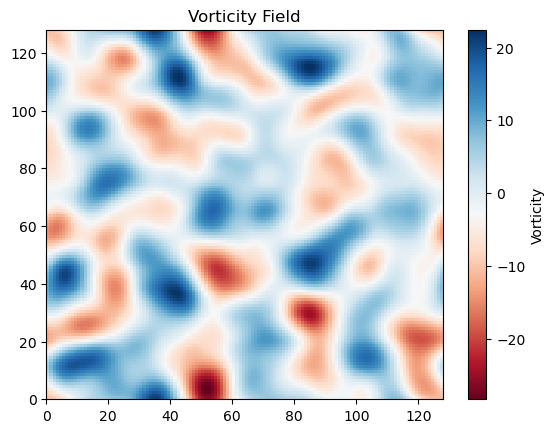

In [139]:
# Define grid and parameters
grid_shape = (128, 128)  # Grid size
device = "cuda" if torch.cuda.is_available() else "cpu"

# Generate divergence-free velocity field
velocity_field = filtered_velocity_field(grid_shape=grid_shape,peak_wavenumber=3.0,device=device)

# Compute vorticity
vorticity_field = compute_vorticity(velocity_field, grid_shape)

# Visualize vorticity
import matplotlib.pyplot as plt
plt.pcolormesh(vorticity_field.cpu().numpy(), cmap="RdBu")
plt.colorbar(label="Vorticity")
plt.title("Vorticity Field")
plt.show()


In [135]:
solver = VorticitySolver2D(N=128, L=1, T=2.0, nu=1e-2, dt=5e-4,num_sol=200, method='CN')

results = solver.run_simulation( vorticity_field.cpu().numpy())

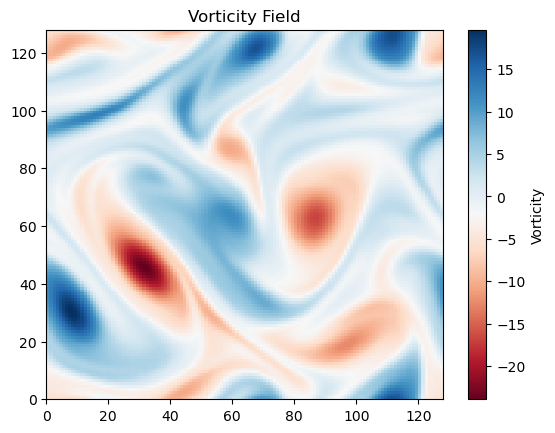

In [136]:
plt.pcolormesh(results[-3], cmap="RdBu")
plt.colorbar(label="Vorticity")
plt.title("Vorticity Field")
plt.show()

In [255]:

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi],[0,config.time_domain]]).to(device)
samples_interior = iter(UniformSampler(dom, batch_size_interior))
batch = next(samples_interior).to(device)

#def initial_conditions_samples(config):
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y, indexing='ij' )  # Create meshgrid for X, Y

dx, dy = X[1, 0] - X[0, 0], Y[0, 1] - Y[0, 0]

torch.manual_seed(config.seed)  # Replace 42 with your desired seed value

# Generate uniformly distributed values for `theta` in the range [-1, 1]
theta = torch.rand(50, 2, 10) * 2 - 1  # Uniform(-1, 1)

w0 = omega0_samples_torch(X, Y, theta)
    
"""Compute initial points and conditions."""
psi = solve_poisson_fft(w0, dx, dy)
u0, v0 = compute_velocity(psi, dx, dy)

initial_points = torch.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), torch.zeros_like(X.reshape(-1, 1))])

w0,u0,v0 = w0.reshape(-1, 10),u0.reshape(-1, 10),v0.reshape(-1,10)

    #return initial_points,w0,u0,v0,theta

In [230]:
# Function to select indices
def sample_indices_ic(size, N, seed):
    with torch.random.fork_rng():  # Isolate RNG
        torch.manual_seed(seed)  # Set the seed
        indices = torch.randperm(size)[:N]  # Generate N random indices
    return indices


def data_set_preparing(data_set, theta):
    theta = theta.view(-1,theta.shape[-1])  # Flatten and repeat

    # Repeat `ini` for the number of columns in `theta`
    num_cols = theta.shape[1]
    data_set_r = data_set.repeat(num_cols, 1)  # Shape (16000, 3)

    # Repeat each column of `theta` to match rows in `ini`
    theta_ = theta.T.repeat_interleave(data_set.shape[0], dim=0)  # Shape (16000, 100)

    # Concatenate along the last dimension
    result = torch.cat((data_set_r, theta_), dim=1)  # Shape (16000, 103)

    return result

In [256]:
indices = sample_indices_ic(initial_points.shape[0], batch_size_interior, 0)

In [260]:
initial_points.shape

torch.Size([16384, 3])

In [258]:
data_set_preparing(initial_points,theta).shape

torch.Size([163840, 103])

In [165]:
initial_points = initial_points[indices]
w0,u0,v0 = w0[indices],u0[indices],v0[indices]

In [225]:
w0.T.reshape(-1,1)[1600:3200]

tensor([[ 0.0004],
        [ 0.0002],
        [-0.0003],
        ...,
        [-0.0007],
        [-0.0002],
        [-0.0007]])

In [238]:
theta_ = theta.view(-1,10)  # Flatten and repeat


In [246]:
theta_[:,1]

tensor([-0.5041, -0.4025, -0.6870, -0.9141, -0.8277,  0.6730,  0.0581, -0.5816,
        -0.3704, -0.2889, -0.8639,  0.9633, -0.7589, -0.8119, -0.3188, -0.7835,
         0.3715,  0.2083,  0.2123, -0.8551, -0.0599, -0.5181, -0.2317,  0.2546,
         0.1139,  0.8640,  0.5637,  0.3541,  0.3095, -0.2369,  0.3488,  0.9168,
         0.5448,  0.6083, -0.8641, -0.4588, -0.8174, -0.7772, -0.2332, -0.9895,
         0.6839, -0.1150,  0.8023,  0.1549, -0.1030,  0.3800,  0.5451, -0.8227,
         0.4758,  0.5159,  0.9765,  0.1207,  0.4999, -0.9535,  0.1491,  0.4170,
         0.3912,  0.2888, -0.1700,  0.7819,  0.2301,  0.5505,  0.8991, -0.8501,
        -0.4625,  0.1757,  0.8193, -0.1986,  0.6951,  0.4819,  0.6252, -0.7215,
        -0.3559,  0.7240,  0.9286,  0.4301,  0.3605, -0.7598, -0.6951,  0.7993,
         0.7495, -0.0530, -0.0406, -0.9434, -0.9795, -0.8218, -0.2715, -0.0793,
         0.7196, -0.4466,  0.9315,  0.0378,  0.4360, -0.4123,  0.0607, -0.2469,
        -0.7561,  0.3959,  0.1612, -0.19

In [250]:
batch

tensor([[0.1821, 2.5252, 0.5197],
        [2.3037, 0.3663, 1.4013],
        [0.3255, 2.9414, 1.3476],
        ...,
        [0.5210, 3.5817, 1.5083],
        [0.2315, 2.4043, 1.7776],
        [3.6619, 3.3007, 1.4168]])

In [247]:
zz = data_set_preparing(batch,theta)

In [252]:
zz[1600,:]

tensor([ 0.1821,  2.5252,  0.5197, -0.5041, -0.4025, -0.6870, -0.9141, -0.8277,
         0.6730,  0.0581, -0.5816, -0.3704, -0.2889, -0.8639,  0.9633, -0.7589,
        -0.8119, -0.3188, -0.7835,  0.3715,  0.2083,  0.2123, -0.8551, -0.0599,
        -0.5181, -0.2317,  0.2546,  0.1139,  0.8640,  0.5637,  0.3541,  0.3095,
        -0.2369,  0.3488,  0.9168,  0.5448,  0.6083, -0.8641, -0.4588, -0.8174,
        -0.7772, -0.2332, -0.9895,  0.6839, -0.1150,  0.8023,  0.1549, -0.1030,
         0.3800,  0.5451, -0.8227,  0.4758,  0.5159,  0.9765,  0.1207,  0.4999,
        -0.9535,  0.1491,  0.4170,  0.3912,  0.2888, -0.1700,  0.7819,  0.2301,
         0.5505,  0.8991, -0.8501, -0.4625,  0.1757,  0.8193, -0.1986,  0.6951,
         0.4819,  0.6252, -0.7215, -0.3559,  0.7240,  0.9286,  0.4301,  0.3605,
        -0.7598, -0.6951,  0.7993,  0.7495, -0.0530, -0.0406, -0.9434, -0.9795,
        -0.8218, -0.2715, -0.0793,  0.7196, -0.4466,  0.9315,  0.0378,  0.4360,
        -0.4123,  0.0607, -0.2469, -0.75

In [181]:
theta.shape

theta_ = theta.view(-1,10)  # Flatten and repeat


In [192]:
# Repeat `ini` for the number of columns in `theta`
num_cols = theta_.shape[1]
repeated_ini = initial_points.repeat(num_cols, 1)  # Shape (16000, 3)

# Repeat each column of `theta` to match rows in `ini`
theta_expanded = theta_.T.repeat_interleave(initial_points.shape[0], dim=0)  # Shape (16000, 100)

# Concatenate along the last dimension
result = torch.cat((repeated_ini, theta_expanded), dim=1)  # Shape (16000, 103)

print(result.shape)

torch.Size([16000, 103])
